<a href="https://colab.research.google.com/github/nabarahim/RA_ECG-Anamolies-Project-FRGS-Fall-2021/blob/main/ECG_Classification_(PTB%2C_MIT_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
df_mitbih_train = pd.read_csv('/content/drive/MyDrive/RA_ECG Anamolies Project FRGS Fall 2021/Dataset/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/content/drive/MyDrive/RA_ECG Anamolies Project FRGS Fall 2021/Dataset/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

df_ptbdb_normal = pd.read_csv('/content/drive/MyDrive/RA_ECG Anamolies Project FRGS Fall 2021/Dataset/ptbdb_normal.csv', header=None)
df_ptbdb_abnormal = pd.read_csv('/content/drive/MyDrive/RA_ECG Anamolies Project FRGS Fall 2021/Dataset/ptbdb_abnormal.csv', header=None)
df_ptbdb = pd.concat([df_ptbdb_normal, df_ptbdb_abnormal], axis=0)

print(df_mitbih.info())
print(df_ptbdb.info())

In [ ]:
# ptbdb
M_ptbdb = df_ptbdb.values
X_ptbdb = M_ptbdb[:,:-1]
y_ptbdb = M_ptbdb[:,-1]

# mitbih
M_mitbih = df_mitbih.values
X_mitbih = M_mitbih[:,:-1]
y_mitbih = M_mitbih[:,-1]

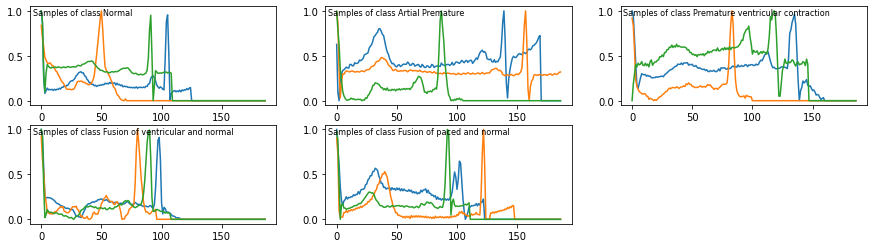

In [ ]:
classes={0:"Normal",
         1:"Artial Premature",
         2:"Premature ventricular contraction",
         3:"Fusion of ventricular and normal",
         4:"Fusion of paced and normal"}
plt.figure(figsize=(15,4))
for i in range(0,5):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(y_mitbih == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_mitbih[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)

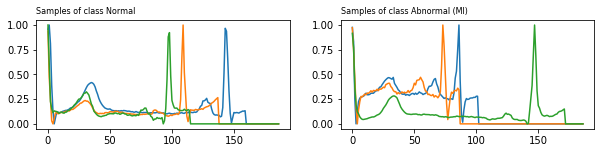

In [ ]:
classes={0:"Normal", 1:"Abnormal (MI)"}
plt.figure(figsize=(10,2))
for i in range(0,2):
    plt.subplot(1,2,i + 1)
    all_samples_indexes = np.where(y_ptbdb == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_ptbdb[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc="left", fontdict={'fontsize':8})

In [ ]:
repartition = df_mitbih[187].astype(int).value_counts()
print(repartition)

0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


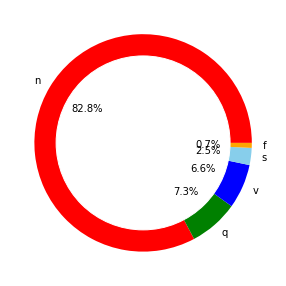

In [ ]:
plt.figure(figsize=(5,5))
circle=plt.Circle( (0,0), 0.8, color='white')
plt.pie(repartition, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
input_shape = (187, 1)

def make_model(final_layer_size=5):
    I = Input(input_shape)
    C = Conv1D(filters=32, kernel_size=5)(I)

    C11 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(C)
    C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
    A11 = Add()([C, C12])
    R11 = Activation(activation='swish')(A11)
    M11 = MaxPool1D(pool_size=5, strides=2)(R11)

    C21 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M11)
    C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
    A21 = Add()([M11, C22])
    R21 = Activation(activation='swish')(A21)
    M21 = MaxPool1D(pool_size=5, strides=2)(R21)

    C31 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M21)
    C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
    A31 = Add()([M21, C32])
    R31 = Activation(activation='swish')(A31)
    M31 = MaxPool1D(pool_size=5, strides=2)(R31)

    C41 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M31)
    C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
    A41 = Add()([M31, C42])
    R41 = Activation(activation='swish')(A41)
    M41 = MaxPool1D(pool_size=5, strides=2)(R41)

    C51 = Conv1D(filters=32, kernel_size=5, activation='swish', padding='same')(M41)
    C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
    A51 = Add()([M41, C52])
    R51 = Activation(activation='swish')(A51)
    M51 = MaxPool1D(pool_size=5, strides=2)(R51)

    F1 = Flatten()(M51)
    D1 = Dense(32)(F1)
    R1 = Activation(activation='swish')(D1)
    D2 = Dense(32)(R1)
    D3 = Dense(final_layer_size)(D2)

    O = Activation(activation='softmax')(D3)

    return Model(inputs=I, outputs=O)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.002, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [ ]:
n_classes = len(np.unique(y_ptbdb))
model_ptbdb = make_model(n_classes)
model_ptbdb.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 183, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 183, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 183, 32)      5152        ['conv1d_1[0][0]']               
                                                                                              

In [ ]:
X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.15)

In [ ]:
model_ptbdb.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_ptbdb.fit(np.expand_dims(X_train_ptbdb, axis=2),
                          y_train_ptbdb,
                          validation_split=0.15,
                          epochs=120,
                          batch_size=40,
                          verbose=0)

In [ ]:
def plot_learning(history):
    plt.subplot(211)
    plt.plot(history.history['accuracy'], color = 'g')
    plt.legend(["accuracy"])
    plt.subplot(212)
    plt.plot(history.history['loss'], color ='red' )
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.legend(["loss", "val_loss"])
    plt.show()

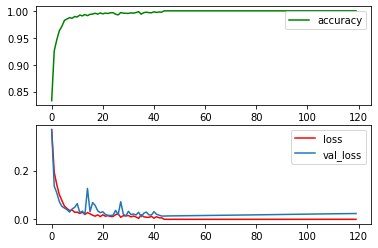

In [ ]:
plot_learning(history)

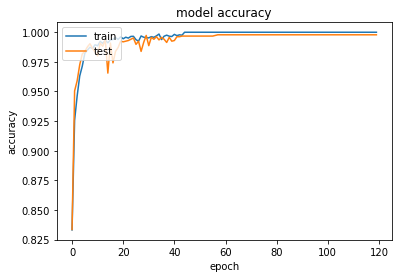

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
unique, counts = np.unique(y_test_ptbdb, return_counts=True)
print(f"The testing set contains {counts[0]} normal recordings and {counts[1]} with myocardial infarction.\nLet's compute the confusion matrix.")

The testing set contains 605 normal recordings and 1578 with myocardial infarction.
Let's compute the confusion matrix.


In [ ]:
results = model_ptbdb.evaluate(np.expand_dims(X_test_ptbdb, axis=2), y_test_ptbdb, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

18/18 [==============================] - 1s 9ms/step - loss: 0.0335 - accuracy: 0.9968
The accuracy on the testing set is 99.7%


In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
y_pred_ptbdb = model_ptbdb.predict(np.expand_dims(X_test_ptbdb, axis=2))
y_pred_ptbdb_bool = np.argmax(y_pred_ptbdb, axis=1)
print(classification_report(y_test_ptbdb, y_pred_ptbdb_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_ptbdb, y_pred_ptbdb_bool)
print(f"Confusion matrix :\n {confusion_matrix}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


##fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       605
         1.0       1.00      1.00      1.00      1578

    accuracy                           1.00      2183
   macro avg       1.00      1.00      1.00      2183
weighted avg       1.00      1.00      1.00      2183

Confusion matrix :
 [[ 601    4]
 [   3 1575]]


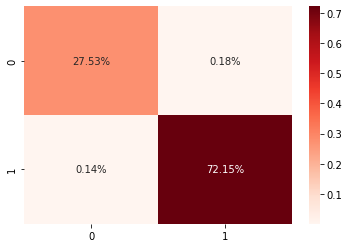

In [ ]:
import seaborn as sns
##sns.heatmap(confusion_matrix, annot=True)

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
            fmt='.2%', cmap='Reds')

In [ ]:
print(f"{confusion_matrix[0][0]}/{counts[0]} MI were correctly classified")

print(f"{confusion_matrix[1][1]}/{counts[1]} normal beats were correctly classified")

print(f"{confusion_matrix[1][0]} beats were classified as MI")

print(f"{confusion_matrix[0][1]} MI were classified as normal")

601/605 MI were correctly classified
1575/1578 normal beats were correctly classified
3 beats were classified as MI
4 MI were classified as normal


In [ ]:
X_train_mitbih, X_test_mitbih, y_train_mitbih, y_test_mitbih = train_test_split(X_mitbih, y_mitbih, test_size=0.15)

In [ ]:
n_classes_mitbih = len(np.unique(y_mitbih))
model_mitbih = make_model(n_classes_mitbih)
model_mitbih.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_mitbih.fit(np.expand_dims(X_train_mitbih, axis=2),
                           y_train_mitbih,
                           validation_split=0.15,
                           epochs=110,
                           batch_size=60,
                           verbose=0)

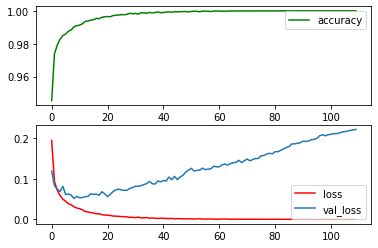

In [ ]:
plot_learning(history)

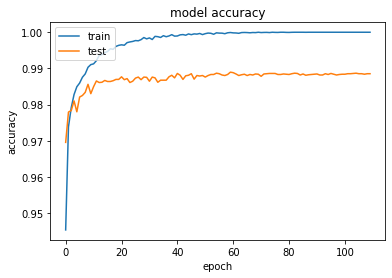

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results = model_mitbih.evaluate(np.expand_dims(X_test_mitbih, axis=2), y_test_mitbih, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

129/129 [==============================] - 0s 4ms/step - loss: 0.2293 - accuracy: 0.9875
The accuracy on the testing set is 98.7%


In [ ]:
predictions = model_mitbih.predict(np.expand_dims(X_test_mitbih, axis=2))
confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, np.argmax(predictions[:], axis=1))
print(confusion_matrix)

tf.Tensor(
[[13513    35    16     7     7]
 [   57   372     5     0     0]
 [   32     3  1041     8     4]
 [   11     0     8   107     0]
 [   13     0     0     0  1178]], shape=(5, 5), dtype=int32)


In [ ]:
y_pred_mitbih = model_mitbih.predict(np.expand_dims(X_test_mitbih, axis=2))
y_pred_mitbih_bool = np.argmax(y_pred_mitbih, axis=1)
print(classification_report(y_test_mitbih, y_pred_mitbih_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, y_pred_mitbih_bool)
print(f"Confusion matrix :\n {confusion_matrix}")

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13578
         1.0       0.91      0.86      0.88       434
         2.0       0.97      0.96      0.96      1088
         3.0       0.88      0.85      0.86       126
         4.0       0.99      0.99      0.99      1191

    accuracy                           0.99     16417
   macro avg       0.95      0.93      0.94     16417
weighted avg       0.99      0.99      0.99     16417

Confusion matrix :
 [[13513    35    16     7     7]
 [   57   372     5     0     0]
 [   32     3  1041     8     4]
 [   11     0     8   107     0]
 [   13     0     0     0  1178]]


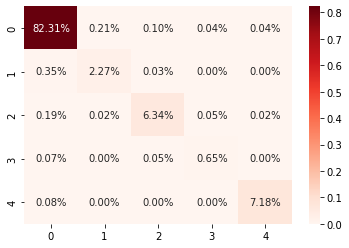

In [ ]:
import seaborn as sns
##sns.heatmap(confusion_matrix, annot=True)

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
            fmt='.2%', cmap='Reds')

In [ ]:
##model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
##param_grid = dict(epochs=[10,20,30])
##grid = GridSearchCV(estimator=model_ptbdb, param_grid=param_grid, n_jobs=-1, cv=3)
##grid_result = grid.fit(X_ptbdb, y_ptbdb)

In [ ]:
##from sklearn.model_selection import GridSearchCV

##search = GridSearchCV(model_mitbih,space, scoring='accuracy', n_jobs=-1, cv=cv)
##result = search.fit(X, y)

In [ ]:
D1 = Dense(32)(model_mitbih.output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)

for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2),
                    y_train_ptbdb,
                    validation_split=0.15,
                    epochs=5,
                    batch_size=128,
                    verbose=0)

In [ ]:
print("Trainability of the layers \n")
for layer in model.layers:
    config = layer.get_config()
    print(f"{config['name']} : {config.get('trainable')}")

Trainability of the layers 

input_2 : None
conv1d_11 : False
conv1d_12 : False
conv1d_13 : False
add_5 : False
activation_7 : False
max_pooling1d_5 : False
conv1d_14 : False
conv1d_15 : False
add_6 : False
activation_8 : False
max_pooling1d_6 : False
conv1d_16 : False
conv1d_17 : False
add_7 : False
activation_9 : False
max_pooling1d_7 : False
conv1d_18 : False
conv1d_19 : False
add_8 : False
activation_10 : False
max_pooling1d_8 : False
conv1d_20 : False
conv1d_21 : False
add_9 : False
activation_11 : False
max_pooling1d_9 : False
flatten_1 : False
dense_3 : False
activation_12 : False
dense_4 : False
dense_5 : False
activation_13 : False
dense_6 : True
dense_7 : True
dense_8 : True


In [ ]:
D1 = Dense(32)(model_mitbih.layers[-3].output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 183, 32)      192         ['input_2[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 183, 32)      5152        ['conv1d_11[0][0]']              
                                                                                                  
 conv1d_13 (Conv1D)             (None, 183, 32)      5152        ['conv1d_12[0][0]']              
                                                                                            

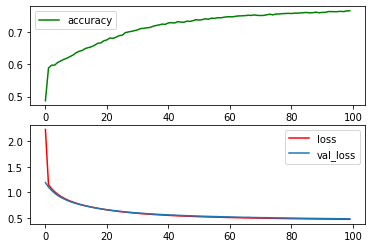

In [ ]:
for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2),
                    y_train_ptbdb,
                    validation_split=0.15,
                    epochs=100,
                    batch_size=128,
                    verbose=0)
plot_learning(history)